In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [6]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [7]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [8]:
def cnvChart(dfCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [9]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [10]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<100)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [11]:
def patientIDFromFilename(filename,findKey):
    patientIDStart = filename.find(findKey)   #
    return filename[patientIDStart:patientIDStart+12]
    #return "GIAB12878"

In [12]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [13]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [14]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos,maxY=1.0,height=5):
    plt.figure(figsize=[18,height])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, maxY])
    plt.show()

In [15]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [16]:
def findPeaks(log_dens):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens))
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens))
    return peaks, troughs

In [17]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

In [18]:
def calculateSomaticCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumSomatic']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumSomatic'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic"  or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumSomatic']
    return dfTumorCNV

### LOAD PON

In [19]:
# Only needs to be run once
#dfPON2 = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

In [20]:
def loadPONvcf(PONFile):
    numHeaderRows = 0
    with open(PONFile) as fp:
        while fp.readline()[0]=='#':
            numHeaderRows = numHeaderRows+1
    dfPON = pd.read_table(PONFile,skiprows =numHeaderRows-1, dtype={'#CHROM':'str','POS':'str'})  #names = CNV_COLUMNS
    dfPON['PON_COUNT'] = dfPON['INFO'].apply(lambda x: x.split('=')[1])
    dfPON.rename(columns={'#CHROM': 'chrom', 'POS': 'pos','REF':'ref','ALT':'alt'}, inplace=True)
    return dfPON

dfPON = loadPONvcf("/Users/peterpriestley/hmf/analyses/PON/PON.vcf")

### FIND ALL FILES

In [22]:
PATH = "/Users/peterpriestley/hmf/analyses/v1.12samples/DRUP01140004/"

In [26]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename,"DRUP0")
cnvFilename = findFiles(PATH,"gz_CNVs")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",cnvFilename

germline = 170518_HMFregDRUP_FR10302004_FR11439413_DRUP01140004.annotatedSLICED.vcf
somatic = DRUP01140004R_DRUP01140004T_melted.vcf
patient = DRUP01140004
CNV = DRUP01140004T_dedup.realigned.pileup.gz_CNVs


### LOAD VCFS

In [27]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID+'T':'melted'},patientID)

reading vcf file: 170518_HMFregDRUP_FR10302004_FR11439413_DRUP01140004.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 341676
reading vcf file: DRUP01140004R_DRUP01140004T_melted.vcf
reading VCF File line: 1
Number variants loaded: 50014


In [28]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PON_COUNT'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PON_COUNT,errors=coerce)>4

### Load BAF and CNV and calculate median BAF per segment

In [29]:
dfBAF = createBAF(dfGermline)

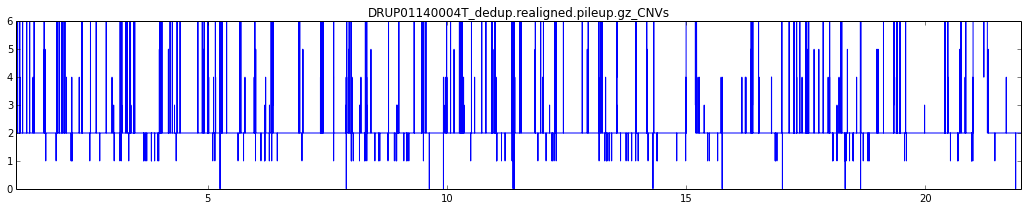

In [30]:
dfCNV = loadCNVforPatient(PATH+cnvFilename,patientID)
dfCNV['mBAF'], dfCNV['mBAFCount'] = np.vectorize(calculateMBAFBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
cnvChart(dfCNV,cnvFilename,1,22)

### TUMOR PURITY

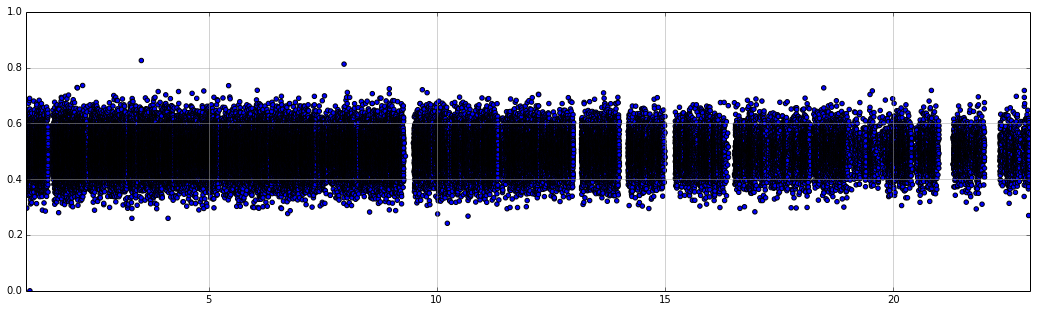

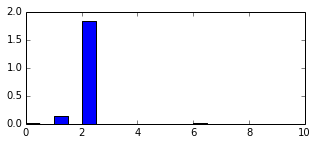

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:8261: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  'this looks transposed (shape is %d x %d)' % x.shape[::-1])


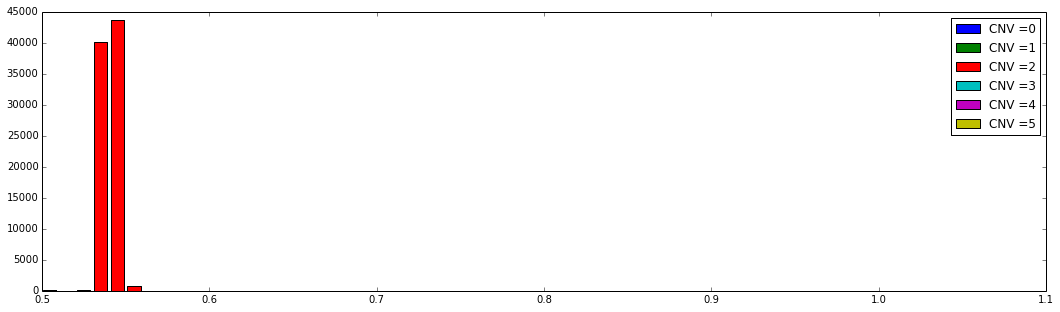

In [31]:
c, fractionMin, fractionMax = 1,0,22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
dftemp = dfCNV[(dfCNV.mBAF>=0.0)&(dfCNV.mBAF<=1.0)&(dfCNV.mBAFCount>20)&(dfCNV.chromPos<=c+fractionMax)&(dfCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,5])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [32]:
dfCNV[(dfCNV.chrom==15)&(dfCNV.mBAFCount>=100)&(dfCNV.copyNum>=1)&(dfCNV.mBAF>=0.50)&(dfCNV.mBAF<=10.63)]

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,score,germlineOrSomatic,oneOrZero,chromPos,cappedCopyNum,regionLength,patientName,mBAF,mBAFCount
885,1255,15,22589000,25772999,2,none,,,0,0,15.220313,2,3183999,DRUP01140004,0.536714,108
889,1257,15,28708000,38749999,2,none,,,0,0,15.279992,2,10041999,DRUP01140004,0.541176,261
891,1258,15,38752000,45903999,2,none,,,0,0,15.377953,2,7151999,DRUP01140004,0.540230,157
893,1259,15,45912000,49544999,2,none,,,0,0,15.447785,2,3632999,DRUP01140004,0.542857,151
895,1260,15,49548000,67631999,2,none,,,0,0,15.483247,2,18083999,DRUP01140004,0.541230,556
903,1264,15,77992000,102531394,2,none,,,0,0,15.760665,2,24539394,DRUP01140004,0.540678,902


### SOMATIC AF

In [33]:
#dfSomatic[(dfSomatic.inPON==False)&(dfSomatic.consensus==True)&(dfSomatic.bedRegion<>"")&((dfSomatic.annWorstImpact=='MODERATE')|(dfSomatic.annWorstImpact=='HIGH'))]

In [34]:
len(dfSomatic[dfSomatic.consensus==True])

3016

In [35]:
pd.pivot_table(dfSomatic[dfSomatic.consensus==True], values='pos', index=['patientName','variantType'], columns=['inPON'], aggfunc='count',margins=False).fillna("")

inPON                     False  True 
patientName  variantType              
DRUP01140004 INDEL          415    897
             SNP            459   1245

In [36]:
pd.pivot_table(dfSomatic[(dfSomatic.variantType == 'SNP')&(dfSomatic.consensus == True)&(dfSomatic.inPON == False)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

meltedallele,A,C,G,T,All
ref,,,,,
A,,46,58,34,138.0
C,22,,27,53,102.0
G,56,19,,14,89.0
T,21,62,47,,130.0
All,99,127,132,101,459.0


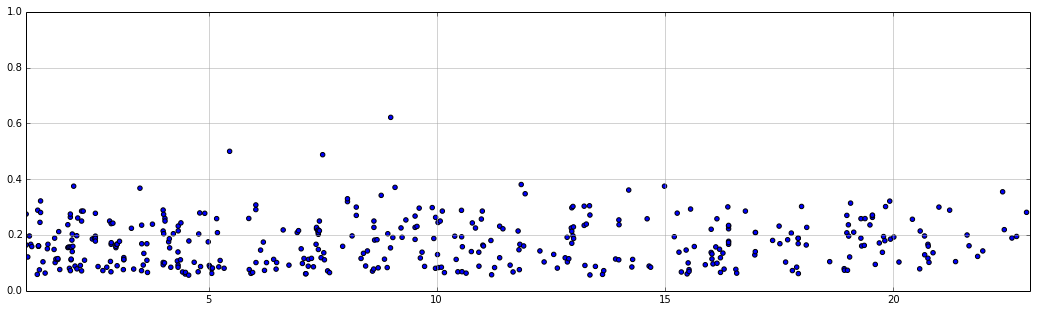

In [49]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax,1)

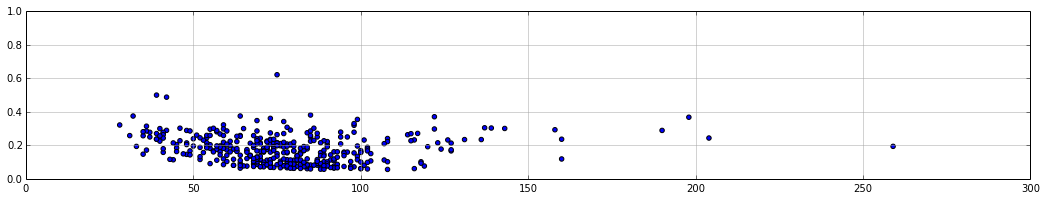

In [38]:
AFByPosPlot(dfSom.meltedDP, dfSom.meltedAF,0, 300,1.0,3)

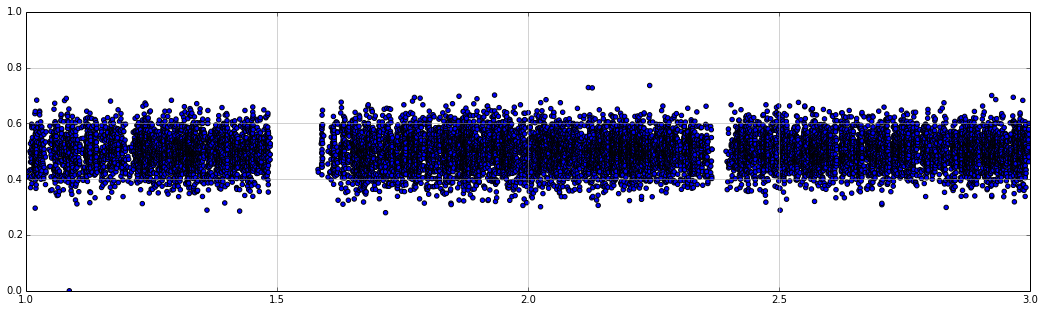

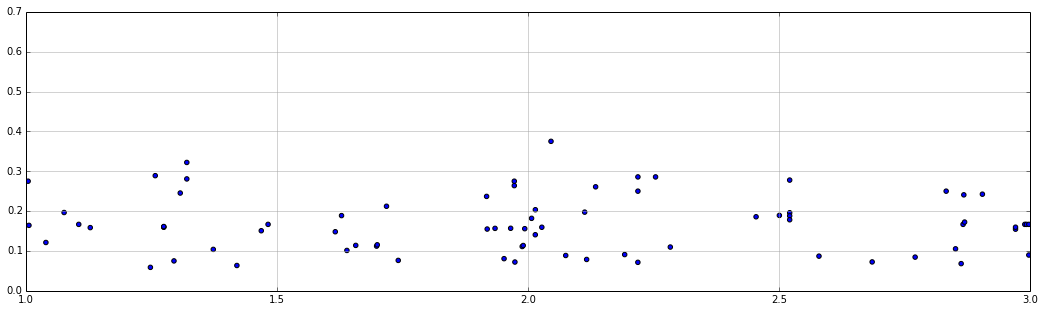

([0.09, 0.16, 0.26, 0.37], [0.12, 0.22, 0.35])

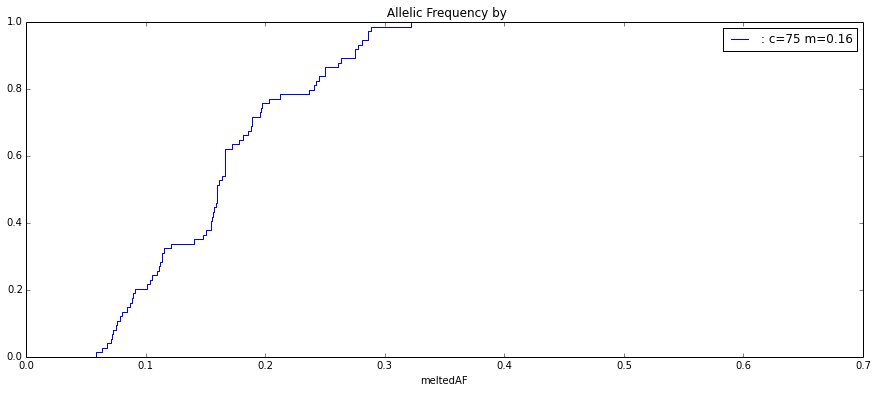

In [39]:
c,fractionMin,fractionMax = 1,0,2
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax,0.7)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6],xlim=[0.0,0.7])

#mbaf
dfCNV[(dfCNV.chromPos>c+fractionMin)&(dfCNV.chromPos<c+fractionMax)&(dfCNV.mBAFCount>500)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

###PEAK
X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(X)
log_dens = kde.score_samples(X_plot)
#pdfChart(log_dens)
findPeaks(log_dens)

### SV ANALYSIS

In [40]:
svVCFFilename = findFiles(PATH,"somaticSV.vcf")[0]
print "SV =",svVCFFilename
print "patient =",patientID

SV = somaticSV.vcf
patient = DRUP01140004


In [41]:
#BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
#BED_FILE_NAME = "cosmicCancerCensus.bed"
#BED_FILE_NAME = "exon6.bed"

In [42]:
dfSV = loadVCF(PATH,svVCFFilename,{patientID+'T':'tumor'},patientID)

reading vcf file: somaticSV.vcf
reading VCF File line: 1
Number variants loaded: 102


In [43]:
pd.pivot_table(dfSV[(dfSV.variantSubType<>"IGN")&(dfSV.tumorAF>=0.001)], values='id', index=['variantSubType'], columns=['variantType'], aggfunc='count').fillna("")

variantType,SV
variantSubType,
BND,72
DEL,15
DUP,7
INV,1


In [44]:
def findMatchingBNDChromPos(df):
    # can 
    df['BNDMatchPos'] = ""
    for i in range(0,df.shape[0]):
        if df.iloc[i]['variantSubType'] == "BND":
            tmp = df.iloc[i]['tumorallele'].find("]")
            if tmp < 0:
                tmp = df.iloc[i]['tumorallele'].find("[")
            if tmp >=0:
                df.iloc[i,df.columns.get_loc('BNDMatchPos')] = df.iloc[i]['tumorallele'][tmp+1:df.iloc[i]['tumorallele'].find("]",tmp+1)]           
    return df

In [45]:
dfSV = findMatchingBNDChromPos(dfSV)

In [46]:
pd.set_option('display.max_rows', 150)

In [201]:
dfSV[(dfSV.bedRegion<>"A")&(dfSV.tumorAF>=0.05)&(dfSV.variantSubType=="BND")][['chrom','pos','chromFrac','variantSubType','bedRegion','BNDMatchPos','tumorAF','tumorDP','tumorSGT','tumorSVLenMin','tumorSVLenMax','tumorSVStartMin','tumorSVStartMax']]

,chrom,pos,chromFrac,variantSubType,bedRegion,BNDMatchPos,tumorAF,tumorDP,tumorSGT,tumorSVLenMin,tumorSVLenMax,tumorSVStartMin,tumorSVStartMax
6,1,26500248,1.106320,BND,Default,11:56332196,0.066038,1,198,0,0,26500248,26500248
13,1,90844048,1.364469,BND,,7:134614403[,0.075758,1,"61,",-298,298,90843750,90844346
16,1,92306960,1.370338,BND,Default,17:75881698,0.091837,1,178,-219,219,92306741,92307179
17,1,96145124,1.385737,BND,Default,17:71473231[TGA,0.083832,1,153,0,0,96145124,96145124
22,1,147019600,1.589846,BND,Default,5:99052593[,0.092784,1,264,-3,0,147019600,147019603
24,1,149891122,1.601367,BND,,19:30104425,0.245098,1,154,0,0,149891122,149891122
64,1,208839035,1.837868,BND,Default,11:103112300,0.099302,1,167,-2,0,208839035,208839037
75,1,216356144,1.868026,BND,Default,19:31274895[,0.247826,1,173,0,0,216356144,216356144
78,1,216701640,1.869413,BND,Default,5:142688374,0.059375,1,301,-344,344,216701296,216701984
87,1,240419493,1.964569,BND,Default,19:29721580[AACCTA,0.056478,1,284,-1,0,240419493,240419494


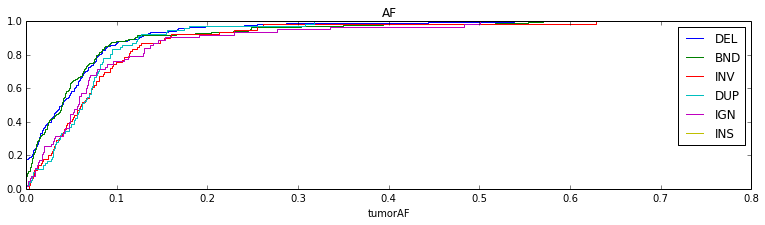

In [202]:
for variantSubType in dfSV.variantSubType.unique():
    ser = dfSV[(dfSV.variantSubType == variantSubType)]["tumorAF"].sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=variantSubType)
    ser_cdf.plot(drawstyle='steps',legend=True,title="AF",figsize=[13,3],xlim=[0.0,0.8],ylim=[0.0,1.0])

### SCRATCH

In [176]:
import random as rand
def randomiseAF(AF):
    return AF +(rand.random()-0.5)/100000
dfGermline['modAF']= dfGermline['normalAF'].apply(lambda x: randomiseAF(x))

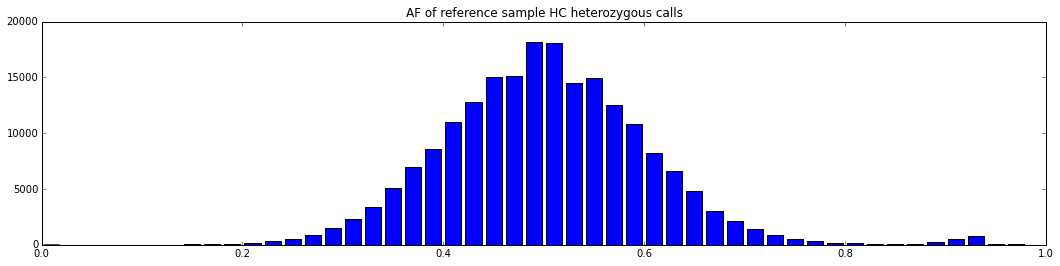

In [177]:
plt.figure(figsize=[18,4])
plt.hist(dfGermline[(dfGermline.chrom <> 'A')&(dfGermline.normalSGT=='0/1')]['modAF'].values,
    cumulative=False, normed=False, bins=50,range=(0.0,1.0),histtype='bar',stacked = False,rwidth=0.8,label=['True','False'])
plt.title('AF of reference sample HC heterozygous calls ')
plt.show()